# Import Modules

In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

from PIL import Image

tf.get_logger().setLevel('INFO')

data_dir='/home/bblouin/winhome/Pictures/LeptonCaptures/data/data'

# Create Dataset Objects

Found 1100 files belonging to 2 classes.
Using 880 files for training.
Found 1100 files belonging to 2 classes.
Using 220 files for validation.
['fire_smoke', 'no-fire']


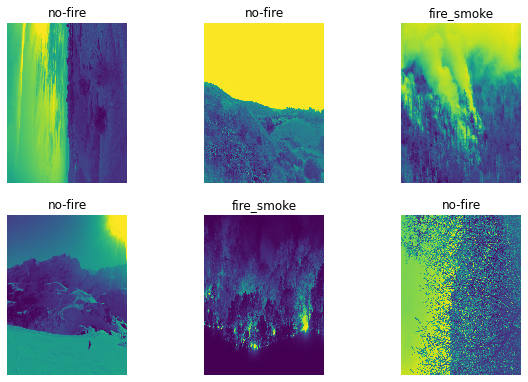

In [2]:
# Generates a tf.data.Dataset from image files in a directory.
# subsets are keywords, see api
# 80% of the images for training, and 20% for validation
# https://keras.io/api/preprocessing/image/

img_height = 160
img_width = 120
img_channels = 1

train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                    subset="training",
                                                    validation_split=0.2,
                                                    seed=np.random.randint(255),
                                                    image_size=(img_height,img_width),
                                                    color_mode='grayscale', 
                                                    batch_size=16) 

val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                    subset="validation",
                                                    validation_split=0.2,
                                                    seed=np.random.randint(255),
                                                    image_size=(img_height,img_width),
                                                    color_mode='grayscale',
                                                    batch_size=16)



# print class names
class_names = train_ds.class_names
print(class_names)

# give examples of images from dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
    
# Speed up by prefectching and caching during model creation
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Create Model

In [3]:
num_classes = 2

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, img_channels)),
  layers.Dense(num_classes * 32, activation='relu'),
  layers.Conv2D(num_classes * 16, 3, strides=2, activation='relu'),
  layers.Dense(num_classes * 16, activation='relu'),
  layers.Dropout(0.5),
  layers.MaxPooling2D(),
  layers.Conv2D(num_classes * 8, 3, strides=2),
  layers.Dense(num_classes * 8, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(num_classes * 4, activation='relu'),
  layers.Dense(num_classes, activation='relu')
])

learning_rate=0.001
opt = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(
  optimizer=opt,
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [4]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose=1
)
model.summary()

Epoch 1/20
55/55 [==============================] - 52s 867ms/step - loss: 0.4824 - accuracy: 0.8211 - val_loss: 0.5176 - val_accuracy: 0.8409
Epoch 2/20
55/55 [==============================] - 15s 267ms/step - loss: 0.4293 - accuracy: 0.8269 - val_loss: 0.4757 - val_accuracy: 0.8409
Epoch 3/20
55/55 [==============================] - 15s 266ms/step - loss: 0.3952 - accuracy: 0.8481 - val_loss: 0.4392 - val_accuracy: 0.8455
Epoch 4/20
55/55 [==============================] - 15s 268ms/step - loss: 0.3694 - accuracy: 0.8547 - val_loss: 0.4043 - val_accuracy: 0.8545
Epoch 5/20
55/55 [==============================] - 15s 270ms/step - loss: 0.3440 - accuracy: 0.8565 - val_loss: 0.3952 - val_accuracy: 0.8591
Epoch 6/20
55/55 [==============================] - 15s 268ms/step - loss: 0.3316 - accuracy: 0.8641 - val_loss: 0.3674 - val_accuracy: 0.8500
Epoch 7/20
55/55 [==============================] - 15s 269ms/step - loss: 0.3227 - accuracy: 0.8614 - val_loss: 0.3545 - val_accuracy: 0.8636

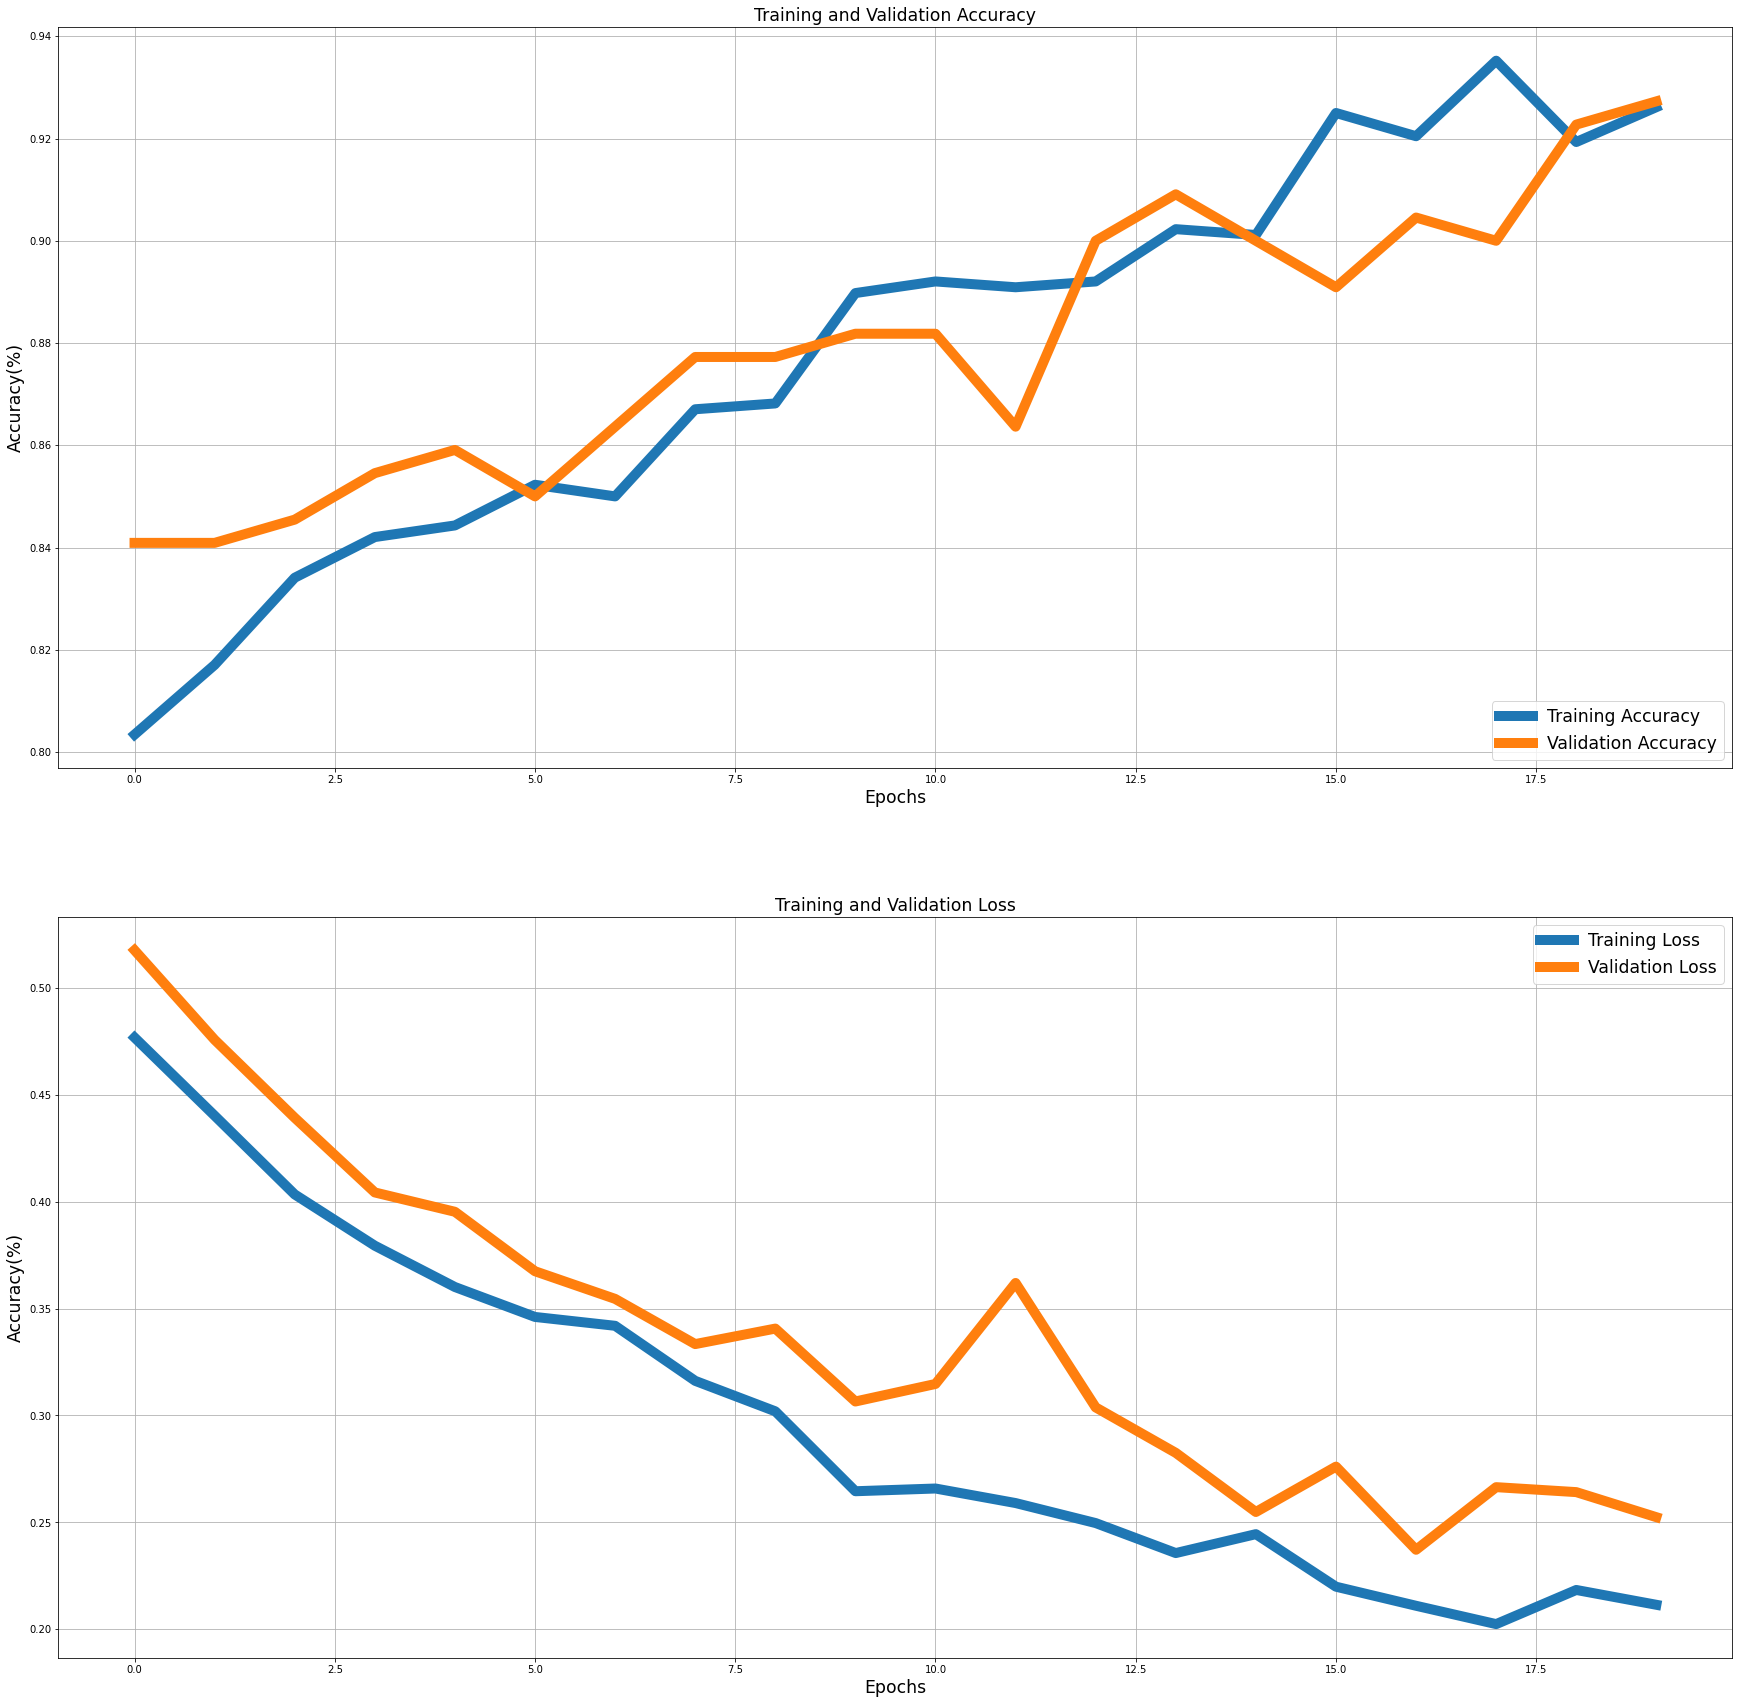

In [5]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(30, 30))
plt.subplot(2, 1, 1)
plt.grid(b=True, which='both', axis='both')
plt.xlabel('Epochs', fontsize='xx-large')
plt.ylabel('Accuracy(%)', fontsize='xx-large')
plt.plot(epochs_range, acc, label='Training Accuracy', linewidth=10)
plt.plot(epochs_range, val_acc, label='Validation Accuracy', linewidth=10)
plt.legend(loc='lower right', fontsize='xx-large')

plt.title('Training and Validation Accuracy', fontsize='xx-large')
plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss', linewidth=10)
plt.grid(b=True, which='both', axis='both')
plt.xlabel('Epochs', fontsize='xx-large')
plt.ylabel('Accuracy(%)', fontsize='xx-large')

plt.plot(epochs_range, val_loss, label='Validation Loss', linewidth=10)
plt.legend(loc='upper right', fontsize='xx-large')
plt.title('Training and Validation Loss',fontsize='xx-large')
plt.show()


'no-fire'

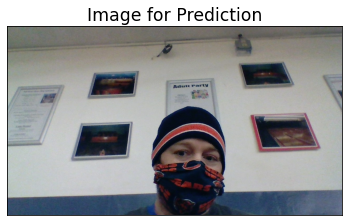

In [18]:
from skimage import transform
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing import image


filename = '/home/bblouin/winhome/Pictures/test.jpg'
np_image = image.load_img(filename, color_mode='grayscale', target_size= (img_height, img_width, img_channels), interpolation='lanczos')
input_arr = keras.preprocessing.image.img_to_array(np_image)
input_arr = np.array([input_arr])  # Convert single image to a batch.

img = mpimg.imread(filename)
plt.title('Image for Prediction',fontsize='xx-large')
plt.tick_params(
    axis='both',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,        # ticks along the left edge are off
    right=False,       # ticks along the right edge are off
    labelleft=False,
    labelbottom=False) # labels along the bottom edge are off
imgplot = plt.imshow(img)

class_names[np.argmax(model.predict(input_arr))]